<a href="https://colab.research.google.com/github/pouya-mhb/DS-ML-DL-Practices/blob/main/DEAM_Regression_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [00:13<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [4]:
files = os.listdir(path)
print("Files and subdirectories in the dataset:")
print(files)

Files and subdirectories in the dataset:
['DEAM_audio', 'DEAM_Annotations', 'features']


In [5]:
# Base dataset path
dataset_path = path

# Define the paths for "DEAM_audio/MEMD_audio" and the static annotations CSV
audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
static_csv = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')

# Print to verify the paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", static_csv)

# Check if the paths exist
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(static_csv):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


In [6]:
song_id = 10  # song ID
audio_path = os.path.join(audio_dir, f"{song_id}.mp3")
audio_path

'/root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio/10.mp3'

In [7]:
y, sr = librosa.load(audio_path, sr=44100, mono=True)
print(f"Audio loaded: {len(y)} samples at {sr} Hz")

Audio loaded: 1987190 samples at 44100 Hz


In [8]:
def compute_mel_spectrogram(y, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Compute mel-spectrogram and convert to dB scale."""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return librosa.power_to_db(mel_spec, ref=np.max)

def load_static_annotations(csv_path, song_id):
    """Load static annotations and extract valence and arousal."""
    df = pd.read_csv(csv_path)
    label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]
    return label

def segment_audio(y, sr, segment_length):
    """Segment audio into fixed-length chunks."""
    segment_samples = segment_length * sr
    return [y[i:i + segment_samples] for i in range(0, len(y), segment_samples)
            if len(y[i:i + segment_samples]) == segment_samples]

# Main script
print("Processing audio data...")

# Convert to mel-spectrogram
mel_spec_db = compute_mel_spectrogram(y=y, sr=sr)
print(f"Mel-spectrogram shape: {mel_spec_db.shape}")

# Load static annotations
label = load_static_annotations(static_csv, song_id)
print(f"Valence: {label[0]}, Arousal: {label[1]}")

# Segment into 5-second chunks (for consistency with CNN)
segment_length = 5  # seconds
segments = segment_audio(y, sr, segment_length)
print(f"Number of 5-second segments: {len(segments)}")

# Compute mel-spectrograms for each segment
mel_specs = np.array([compute_mel_spectrogram(segment, sr) for segment in segments])
print(f"Shape of each segment's mel-spectrogram: {mel_specs[0].shape}")


Processing audio data...
Mel-spectrogram shape: (128, 3882)
Valence: 4.0, Arousal: 4.7
Number of 5-second segments: 9
Shape of each segment's mel-spectrogram: (128, 431)


Visualizing data...


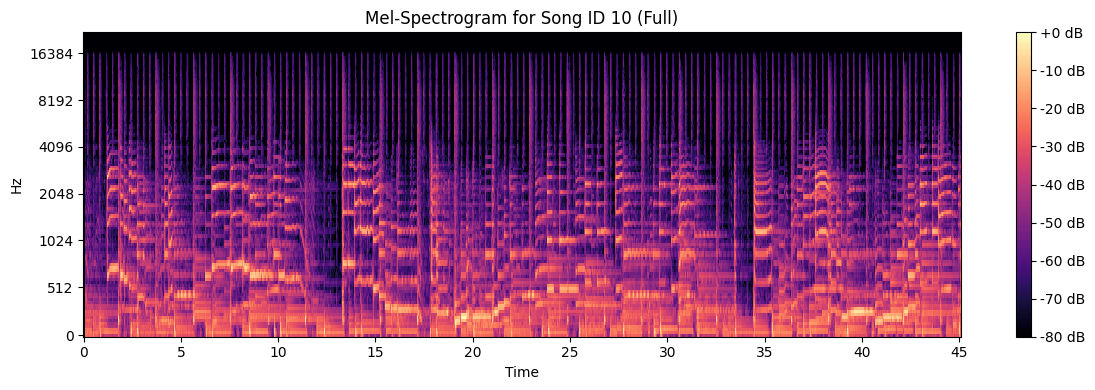

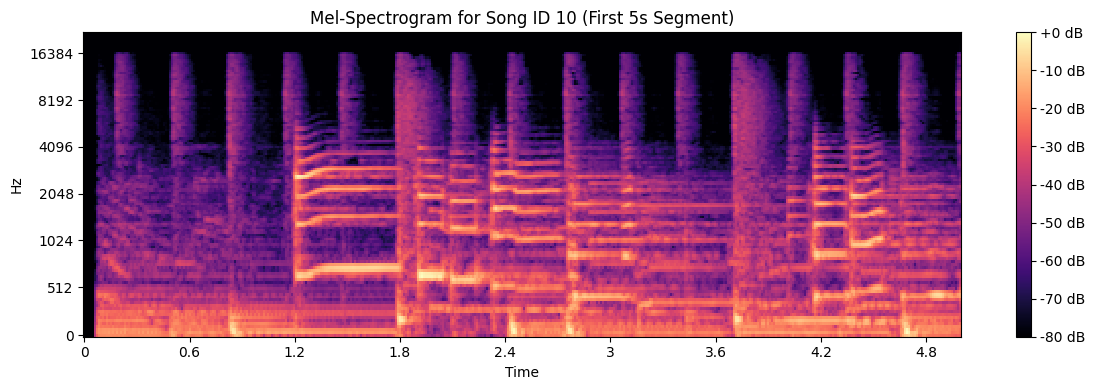

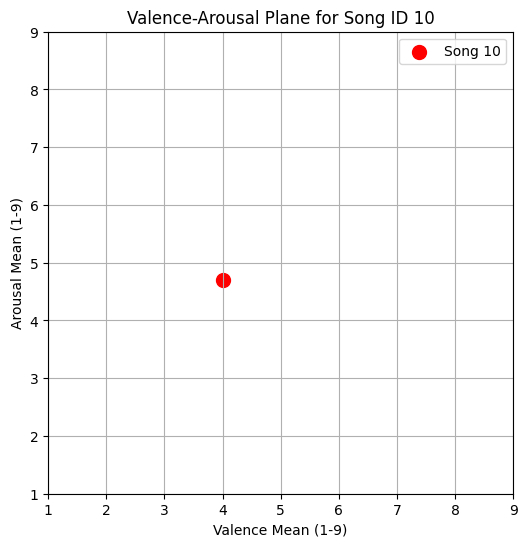

In [9]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_full_mel_spectrogram(mel_spec_db, sr, song_id, hop_length=512):
    """Visualize the full mel-spectrogram."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram for Song ID {song_id} (Full)')
    plt.tight_layout()
    plt.show()

def visualize_first_segment_mel_spectrogram(mel_spec_segment, sr, song_id, hop_length=512):
    """Visualize the mel-spectrogram of the first segment."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_segment, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram for Song ID {song_id} (First 5s Segment)')
    plt.tight_layout()
    plt.show()

def plot_valence_arousal_plane(label, song_id):
    """Plot valence and arousal on a 2D plane."""
    plt.figure(figsize=(6, 6))
    plt.scatter(label[0], label[1], color='red', s=100, label=f'Song {song_id}')
    plt.xlabel('Valence Mean (1-9)')
    plt.ylabel('Arousal Mean (1-9)')
    plt.title(f'Valence-Arousal Plane for Song ID {song_id}')
    plt.xlim(1, 9)
    plt.ylim(1, 9)
    plt.grid(True)
    plt.legend()
    plt.show()

# Main script
print("Visualizing data...")

# 1. Visualize full mel-spectrogram
visualize_full_mel_spectrogram(mel_spec_db, sr, song_id)

# 2. Visualize first segment's mel-spectrogram
visualize_first_segment_mel_spectrogram(mel_specs[0], sr, song_id)

# 3. Plot valence-arousal on 2D plane
plot_valence_arousal_plane(label, song_id)


Adding a threshold to the process_all_songs function can help filter out audio segments or mel-spectrograms that do not meet a specific quality criterion or other requirements (e.g., amplitude thresholds, segment length constraints, etc.)

In [19]:
# def process_audio_file(audio_path, sr=44100, segment_length=5):
#     """Load audio, segment it into fixed-length chunks, and return segments."""
#     try:
#         y_full, sr = librosa.load(audio_path, sr=sr, mono=True)
#         segment_samples = segment_length * sr
#         segments = [
#             y_full[i:i + segment_samples]
#             for i in range(0, len(y_full), segment_samples)
#             if len(y_full[i:i + segment_samples]) == segment_samples
#         ]
#         return segments, sr
#     except Exception as e:
#         print(f"Error loading audio file {audio_path}: {e}")
#         return None, sr

def process_audio_file_with_threshold(audio_path, sr=44100, segment_length=5, amplitude_threshold=0.01):
    """
    Load audio, segment it into fixed-length chunks, apply amplitude threshold,
    and return valid segments.
    """
    try:
        y_full, sr = librosa.load(audio_path, sr=sr, mono=True)
        segment_samples = segment_length * sr
        segments = []
        for i in range(0, len(y_full), segment_samples):
            segment = y_full[i:i + segment_samples]
            if len(segment) == segment_samples and np.max(np.abs(segment)) > amplitude_threshold:
                segments.append(segment)
        return segments, sr
    except Exception as e:
        print(f"Error loading audio file {audio_path}: {e}")
        return None, sr

def compute_mel_specs(segments, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Compute mel-spectrograms for a list of audio segments."""
    mel_specs = []
    for segment in segments:
        try:
            mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_specs.append(mel_spec_db)
        except Exception as e:
            print(f"Error computing mel-spectrogram: {e}")
    return mel_specs

def get_labels(df, song_id):
    """Extract valence and arousal labels for a song."""
    try:
        label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]
        return label
    except Exception as e:
        print(f"Error fetching labels for song ID {song_id}: {e}")
        return None

# def process_all_songs(df, audio_dir, segment_length=5):
#     """Process all songs: load audio, segment, compute mel-spectrograms, and store labels."""
#     X_by_song = {}
#     y_by_song = {}

#     for song_id in df['song_id'].values:
#         audio_path = os.path.join(audio_dir, f"{song_id}.mp3")
#         print(f"Processing song {song_id}...")

#         segments, sr = process_audio_file(audio_path, segment_length=segment_length)
#         if segments is None:
#             continue

#         label = get_labels(df, song_id)
#         if label is None:
#             continue

#         mel_specs = compute_mel_specs(segments, sr)
#         X_by_song[song_id] = mel_specs
#         y_by_song[song_id] = [label] * len(mel_specs)  # Raw labels (1-9 scale)

#     return X_by_song, y_by_song

def process_all_songs_with_limit(df, audio_dir, segment_length=5, amplitude_threshold=0.01, max_songs=1000):
    """
    Process a limited number of songs: load audio, segment, apply threshold,
    compute mel-spectrograms, and store labels.
    """
    X_by_song = {}
    y_by_song = {}
    processed_count = 0  # Keep track of the number of processed songs

    for song_id in df['song_id'].values:
        if processed_count == max_songs:
            print(f"Reached the limit of {max_songs} songs. Stopping processing.")
            break

        audio_path = os.path.join(audio_dir, f"{song_id}.mp3")
        print(f"Processing song {song_id}...")

        # Process audio with threshold
        segments, sr = process_audio_file_with_threshold(audio_path, segment_length=segment_length,
                                                          amplitude_threshold=amplitude_threshold)
        if segments is None or len(segments) == 0:
            print(f"Song {song_id} skipped: No valid segments after applying threshold.")
            continue

        # Fetch labels for the song
        label = get_labels(df, song_id)
        if label is None:
            continue

        # Compute mel-spectrograms
        mel_specs = compute_mel_specs(segments, sr)
        X_by_song[song_id] = mel_specs
        y_by_song[song_id] = [label] * len(mel_specs)  # Raw labels (1-9 scale)

        processed_count += 1

    return X_by_song, y_by_song

# Main script
print("Starting data processing...")
df = pd.read_csv(static_csv)
# X_by_song, y_by_song = process_all_songs(df, audio_dir)
X_by_song, y_by_song = process_all_songs_with_limit(df, audio_dir, amplitude_threshold=0.01, max_songs=100)
print("Data loading and mel-spectrogram extraction complete.")


Starting data processing...
Processing song 2...
Processing song 3...
Processing song 4...
Processing song 5...
Processing song 7...
Processing song 8...
Processing song 10...
Processing song 12...
Processing song 13...
Processing song 17...
Processing song 18...
Processing song 19...
Processing song 20...
Processing song 21...
Processing song 22...
Processing song 24...
Processing song 25...
Processing song 31...
Processing song 32...
Processing song 35...
Processing song 37...
Processing song 39...
Processing song 40...
Processing song 41...
Processing song 42...
Processing song 43...
Processing song 44...
Processing song 45...
Processing song 46...
Processing song 47...
Processing song 48...
Processing song 49...
Processing song 50...
Processing song 51...
Processing song 52...
Processing song 53...
Processing song 54...
Processing song 55...
Processing song 56...
Processing song 58...
Processing song 59...
Processing song 60...
Processing song 62...
Processing song 64...
Processing

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

def get_song_ids(X_by_song):
    """Get a list of song IDs."""
    return list(X_by_song.keys())
"""
Training: 70% of the data
Validation: 15% of the data
Test: 15% of the data
"""
def split_song_ids(song_ids, test_size=0.3, val_size=0.5, random_state=42):
    """Split song IDs into train, validation, and test sets."""
    train_ids, temp_ids = train_test_split(song_ids, test_size=test_size, random_state=random_state)
    val_ids, test_ids = train_test_split(temp_ids, test_size=val_size, random_state=random_state)
    return train_ids, val_ids, test_ids

def flatten_segments_and_labels(song_ids, X_by_song, y_by_song):
    """Flatten song-level data into segment-level lists."""
    X, y = [], []
    for sid in song_ids:
        X.extend(X_by_song[sid])
        y.extend(y_by_song[sid])
    return np.array(X), np.array(y)

def expand_dimensions(X):
    """Expand dimensions for CNN or LSTM input."""
    return np.expand_dims(X, axis=-1)

def process_and_split_data(X_by_song, y_by_song):
    """Process song IDs, split data, and prepare it for training."""
    song_ids = get_song_ids(X_by_song)
    train_ids, val_ids, test_ids = split_song_ids(song_ids)

    # Flatten into segment-level data
    X_train, y_train = flatten_segments_and_labels(train_ids, X_by_song, y_by_song)
    X_val, y_val = flatten_segments_and_labels(val_ids, X_by_song, y_by_song)
    X_test, y_test = flatten_segments_and_labels(test_ids, X_by_song, y_by_song)

    # Expand dimensions
    X_train = expand_dimensions(X_train)
    X_val = expand_dimensions(X_val)
    X_test = expand_dimensions(X_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Main script
print("Processing and splitting data...")

(X_train, y_train), (X_val, y_val), (X_test, y_test) = process_and_split_data(X_by_song, y_by_song)

print(f"Train segments: {X_train.shape}, Val segments: {X_val.shape}, Test segments: {X_test.shape}")
print(f"Train labels: {y_train.shape}, Val labels: {y_val.shape}, Test labels: {y_test.shape}")


Processing and splitting data...
Train segments: (630, 128, 431, 1), Val segments: (135, 128, 431, 1), Test segments: (135, 128, 431, 1)
Train labels: (630, 2), Val labels: (135, 2), Test labels: (135, 2)


In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def initialize_scaler(feature_range=(0, 1)):
    """Initialize and return a MinMaxScaler with the specified feature range."""
    return MinMaxScaler(feature_range=feature_range)

def fit_scaler_on_training_labels(y_train):
    """Fit the MinMaxScaler on training labels only."""
    y_train_2d = y_train.reshape(-1, 2)  # Flatten to 2D for the scaler
    scaler = initialize_scaler()
    scaler.fit(y_train_2d)  # Compute min and max from training set only
    return scaler

def normalize_labels(y_set, scaler):
    """Normalize a label set using the fitted scaler."""
    y_set_normalized = scaler.transform(y_set.reshape(-1, 2)).reshape(y_set.shape)
    return y_set_normalized

def print_normalization_info(scaler, y_train_normalized, y_val_normalized, y_test_normalized):
    """Print scaler range and examples of normalized labels."""
    print(f"Training label min: {scaler.data_min_}, max: {scaler.data_max_}")
    print(f"Normalized training label example: {y_train_normalized[0]}")
    print(f"Normalized validation label example: {y_val_normalized[0]}")
    print(f"Normalized test label example: {y_test_normalized[0]}")

# Main script
print("Normalizing labels...")

# Fit scaler on training labels
scaler = fit_scaler_on_training_labels(y_train)

# Normalize all sets
y_train_normalized = normalize_labels(y_train, scaler)
y_val_normalized = normalize_labels(y_val, scaler)
y_test_normalized = normalize_labels(y_test, scaler)

# Display results
print_normalization_info(scaler, y_train_normalized, y_val_normalized, y_test_normalized)


Normalizing labels...
Training label min: [2.9 2.1], max: [8.4 7.8]
Normalized training label example: [0.54545455 0.38596491]
Normalized validation label example: [0.18181818 0.49122807]
Normalized test label example: [0.47272727 0.43859649]


# Simple CNN model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_cnn(input_shape=(128, 431, 1)):
    """Define a CNN model for audio-based input."""
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularization to prevent overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='linear'))  # Output layer (valence, arousal)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error
    return model

# Create and summarize the model
cnn_model = create_cnn()
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 429, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 429, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 214, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 212, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 212, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 106, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 104, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 104, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 93184)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      11,927,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,029,634 (45.89 MB)

 Trainable params: 12,029,186 (45.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
# Train model
history = cnn_model.fit(X_train, y_train_normalized,
                    validation_data=(X_val, y_val_normalized),
                    epochs=100, batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10),
                               tf.keras.callbacks.ModelCheckpoint("simple_cnn_model.keras", save_best_only=True)])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 567ms/step - loss: 282.5761 - mae: 9.8370 - val_loss: 313.8822 - val_mae: 14.1876
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 3.3574 - mae: 0.7419 - val_loss: 12.2413 - val_mae: 2.8618
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.6489 - mae: 0.4658 - val_loss: 10.6790 - val_mae: 2.3027
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.3380 - mae: 0.4127 - val_loss: 0.6630 - val_mae: 0.5176
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.2346 - mae: 0.3961 - val_loss: 0.3216 - val_mae: 0.4156
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.1851 - mae: 0.3742 - val_loss: 0.2118 - val_mae: 0.3600
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.1851 - mae: 0.3680 - val_loss: 0.1810 - val_mae: 0.3548
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1614 - mae: 0.3447 - val_loss: 0.1737 - val_mae: 0.3537
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [24]:
test_loss, test_mae = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 20.6231 - mae: 4.3928
Test Loss: 19.510177612304688, Test MAE: 4.264398574829102


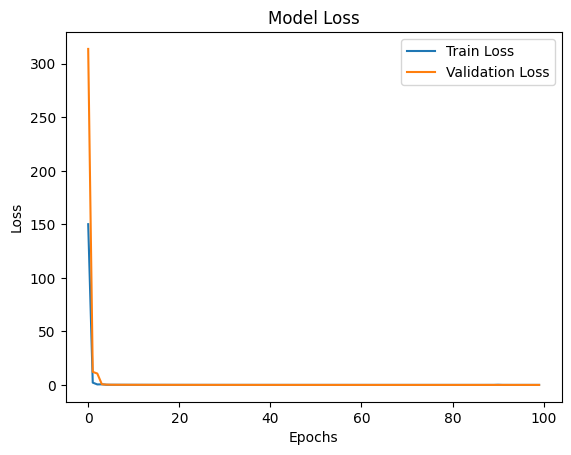

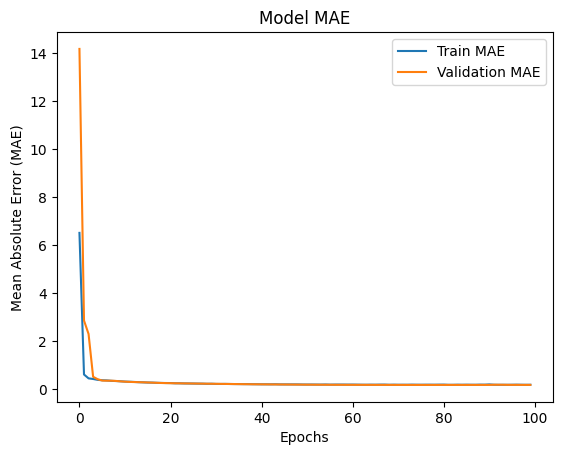

In [25]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Model MAE')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


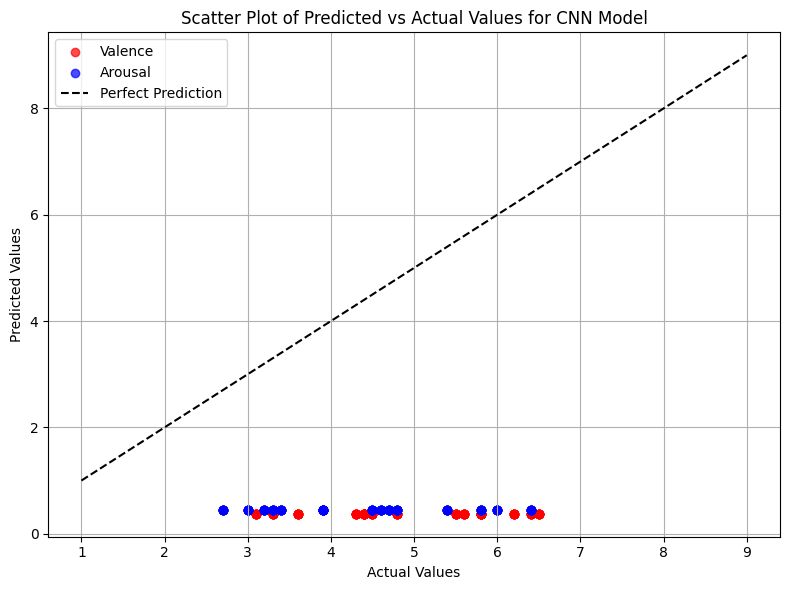

In [49]:
import matplotlib.pyplot as plt

# Generate predictions using your CNN model
y_pred = cnn_model.predict(X_test)

# Scatter plot to compare predicted and actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], label='Valence', alpha=0.7, color='r')
plt.scatter(y_test[:, 1], y_pred[:, 1], label='Arousal', alpha=0.7, color='b')
plt.plot([1, 9], [1, 9], 'k--', label='Perfect Prediction')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values for CNN Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predict on the test set
y_pred = cnn_model.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R² (Coefficient of Determination): {r2}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² (Coefficient of Determination): -15.248162950956702
Root Mean Squared Error (RMSE): 4.417032589452862


In [32]:
import numpy as np

def compute_accuracy(y_true, y_pred, threshold=0.1):
    """
    Compute accuracy for regression-like tasks using a threshold.
    A prediction is considered correct if the absolute difference
    between the predicted and true values is within the threshold.
    """
    # Calculate absolute differences
    differences = np.abs(y_true - y_pred)

    # Check if differences are within the threshold
    correct_predictions = np.all(differences <= threshold, axis=1)

    # Calculate accuracy
    accuracy = np.mean(correct_predictions) * 100  # Convert to percentage
    return accuracy

# Example: Compute accuracy
threshold = 0.1  # Tolerance for correctness
y_pred = cnn_model.predict(X_test)  # Predictions
accuracy = compute_accuracy(y_test, y_pred, threshold=threshold)
print(f"Model Accuracy within threshold {threshold}: {accuracy:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model Accuracy within threshold 0.1: 0.00%


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


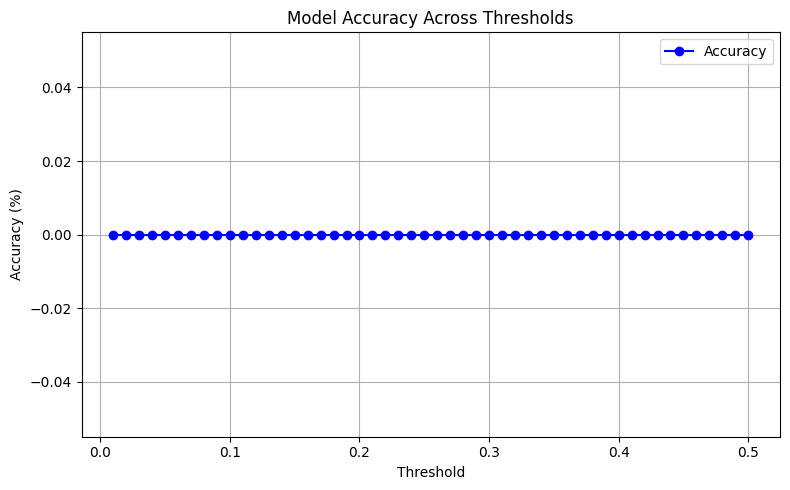

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def compute_accuracy(y_true, y_pred, threshold):
    """
    Compute accuracy for a regression-like task with a given threshold.
    A prediction is considered correct if the absolute difference
    between the predicted and true values is within the threshold.
    """
    differences = np.abs(y_true - y_pred)
    correct_predictions = np.all(differences <= threshold, axis=1)
    accuracy = np.mean(correct_predictions) * 100  # Percentage
    return accuracy

def evaluate_accuracy_across_thresholds(y_true, y_pred, thresholds):
    """
    Evaluate model accuracy across multiple thresholds.
    Returns a list of accuracies for the given thresholds.
    """
    accuracies = [compute_accuracy(y_true, y_pred, t) for t in thresholds]
    return accuracies

# Define thresholds to evaluate
thresholds = np.linspace(0.01, 0.5, 50)  # From 0.01 to 0.5 in 50 steps

# Predict values
y_pred = cnn_model.predict(X_test)

# Evaluate accuracy for each threshold
accuracies = evaluate_accuracy_across_thresholds(y_test, y_pred, thresholds)

# Plot accuracy vs thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Across Thresholds')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# Evaluate model
y_pred = cnn_model.predict(X_test)
mae_valence = np.mean(np.abs(y_pred[:, 0] - y_test_normalized[:, 0]))
mae_arousal = np.mean(np.abs(y_pred[:, 1] - y_test_normalized[:, 1]))
print(f"Test MAE - Valence: {mae_valence:.4f}, Arousal: {mae_arousal:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Model Accuracy within threshold 0.1: 0.00%


In [27]:
# Additional metrics
mse_valence = np.mean((y_pred[:, 0] - y_test_normalized[:, 0]) ** 2)
mse_arousal = np.mean((y_pred[:, 1] - y_test_normalized[:, 1]) ** 2)
rmse_valence = np.sqrt(mse_valence)
rmse_arousal = np.sqrt(mse_arousal)
print(f"Test MSE - Valence: {mse_valence:.4f}, Arousal: {mse_arousal:.4f}")
print(f"Test RMSE - Valence: {rmse_valence:.4f}, Arousal: {rmse_arousal:.4f}")

Test MSE - Valence: 0.0402, Arousal: 0.0415
Test RMSE - Valence: 0.2005, Arousal: 0.2037


# Hybrid Model CNN-RNN

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.layers import TimeDistributed, Reshape

def create_cnn_rnn(input_shape=(128, 431, 1)):
    """Define a hybrid CNN-RNN model for audio-based input."""
    model = Sequential()

    # Convolutional Layers (Feature extraction)
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Reshape for RNN/LSTM
    # Assume the resulting shape is (None, time_steps, features)
    model.add(Reshape(target_shape=(-1, 128)))  # Flatten frequency and channel dimensions

    # LSTM Layers (Temporal feature extraction)
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Bidirectional LSTM
    model.add(Bidirectional(LSTM(64)))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularization to prevent overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='linear'))  # Output layer for valence and arousal

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Adjust loss/metrics as needed

    return model

# Create and summarize the model
hybrid_model = create_cnn_rnn()
hybrid_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 429, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 126, 429, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 214, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 212, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 212, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 106, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 104, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 104, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 728, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 728, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 545,986 (2.08 MB)

 Trainable params: 545,538 (2.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
# Train model
history = hybrid_model.fit(X_train, y_train_normalized,
                    validation_data=(X_val, y_val_normalized),
                    epochs=50, batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10),
                               tf.keras.callbacks.ModelCheckpoint("hybrid_cnn_rnn_model.keras", save_best_only=True)])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - loss: 0.1268 - mae: 0.2807 - val_loss: 0.0791 - val_mae: 0.2111
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0529 - mae: 0.1821 - val_loss: 0.0605 - val_mae: 0.1918
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - loss: 0.0523 - mae: 0.1860 - val_loss: 0.0884 - val_mae: 0.2334
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - loss: 0.0462 - mae: 0.1730 - val_loss: 0.0776 - val_mae: 0.2156
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.0434 - mae: 0.1674 - val_loss: 0.0823 - val_mae: 0.2229
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 0.0412 - mae: 0.1627 - val_loss: 0.0833 - val_mae: 0.2242
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - loss: 0.0391 - mae: 0.1587 - val_loss: 0.0475 - val_mae: 0.1668
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 0.0382 - mae: 0.1559 - val_loss: 0.0638 - val_mae: 0.1920
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - 

In [42]:
test_loss, test_mae = hybrid_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 21.4272 - mae: 4.4939
Test Loss (MSE): 20.325359344482422
Test Mean Absolute Error (MAE): 4.372693061828613


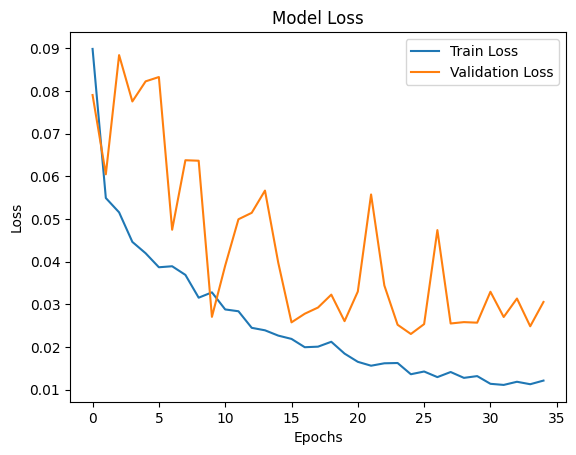

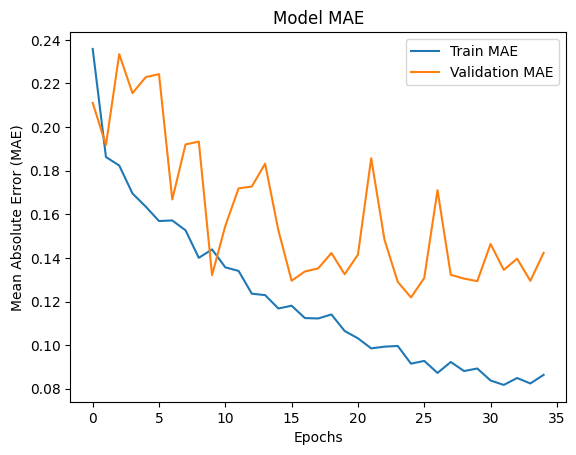

In [43]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Model MAE')
plt.show()


In [44]:
y_pred = hybrid_model.predict(X_test)

# Example: Compare first 5 predictions with actual values
for i in range(5):
    print(f"Predicted: {y_pred[i]}, Actual: {y_test[i]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
Predicted: [0.5086771 0.5262282], Actual: [5.5 4.6]
Predicted: [0.31060705 0.4486999 ], Actual: [5.5 4.6]
Predicted: [0.28951776 0.3087107 ], Actual: [5.5 4.6]
Predicted: [0.5020034  0.41521573], Actual: [5.5 4.6]
Predicted: [0.39069635 0.45351964], Actual: [5.5 4.6]


In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 4.508365582796306
R² Score: -15.919969652791565


In [48]:
def compute_accuracy(y_true, y_pred, threshold=0.1):
    differences = np.abs(y_true - y_pred)
    correct_predictions = np.all(differences <= threshold, axis=1)
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

# Compute accuracy with a threshold (e.g., 0.1)
threshold = 0.1
accuracy = compute_accuracy(y_test, y_pred, threshold=threshold)
print(f"Model Accuracy within threshold {threshold}: {accuracy:.2f}%")


Model Accuracy within threshold 0.1: 0.00%


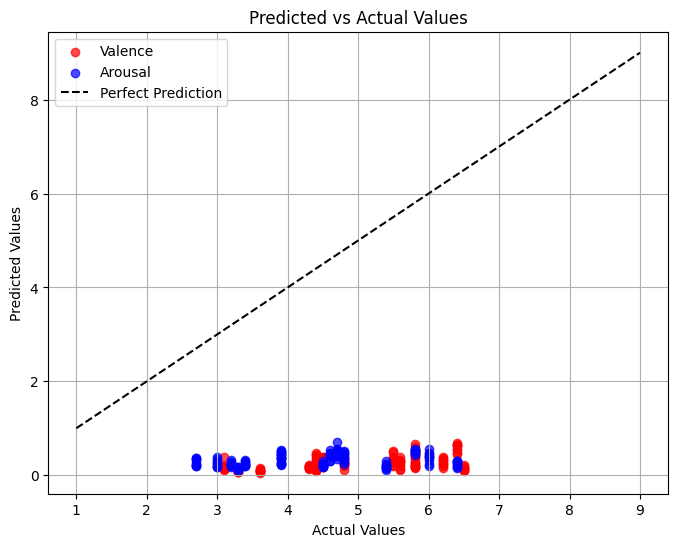

In [47]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], label='Valence', alpha=0.7, color='r')
plt.scatter(y_test[:, 1], y_pred[:, 1], label='Arousal', alpha=0.7, color='b')
plt.plot([1, 9], [1, 9], 'k--', label='Perfect Prediction')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.show()
